# Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval as ms
from statsFuncs import compDistributions
import scipy
import random

mpl.rcParams['axes.linewidth'] = 2

# Paths 

In [2]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'

# Plot params

In [3]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Subject params 

In [4]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

118 files, 13 folders
12 subjects


In [5]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

# Load data 

In [6]:
alldata = pd.DataFrame(columns=['SUBJECT', 'trialNumber', 'shifted_stimulusID', 'shifted_morphID', 'Error', 'responseError'])
# alldata_trimed = pd.DataFrame(columns=['SUBJECT', 'AVG_RESPONSE_ERROR'])

row = 0
for subject in subject_names:
    subjectdata_temp = pd.DataFrame()
    print(subject)
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata_temp = subjectdata[['trialNumber', 'shifted_stimulusID', 'shifted_morphID', 'Error', 'responseError']]
    subjectdata_temp = subjectdata_temp[(subjectdata_temp['trialNumber'] >= 1) & (subjectdata_temp['trialNumber'] <= 184)]
    print(len(subjectdata_temp))
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    

    if subject == 'S1':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    
    row += 1
    
alldata['responseError'] = abs(alldata['responseError'])
alldata['Error'] = abs(alldata['Error'])



S1
250
S3
243
S4
247
S6
249
S7
248
S8
246
s9
248
s10
249
s11
246
s12
247
s13
247
s14
251
s15
245


# Polar plot

## Means per location 

In [7]:
# we have 147 locations
by_loc_by_subject = alldata.groupby(by=['SUBJECT', 'shifted_stimulusID'], as_index=False).mean()
by_loc_by_subject

,SUBJECT,shifted_stimulusID,trialNumber,shifted_morphID,Error,responseError
0,S1,1.0,65.0,140.0,7.0,4.276108
1,S1,2.0,45.5,131.5,16.5,4.055449
2,S1,3.0,65.0,142.0,7.0,6.359337
3,S1,4.0,8.0,134.0,16.0,1.932613
4,S1,5.0,54.5,66.5,11.5,10.500000
...,...,...,...,...,...,...
1740,s9,143.0,24.0,146.0,3.0,1.016698
1741,s9,144.0,46.0,144.0,0.0,2.963078
1742,s9,145.0,80.0,1.0,2.0,0.304789
1743,s9,146.0,73.0,6.0,6.0,5.796765


## Corrected Error 

In [8]:
# alldata.dropna(inplace=True)
shifted_stimulus_df = pd.DataFrame(columns=['shifted_stimulusID', 'responseError', 'responseError_SEM'])

row=0

for stimulus in alldata.shifted_stimulusID.unique():
    
    tmp = alldata[alldata['shifted_stimulusID'] == stimulus]
    
    mean_stimulus, sem_stimulus = ms.mean_sem_returnsem(tmp['responseError'])
    shifted_stimulus_df.loc[row, 'shifted_stimulusID'] = stimulus
    shifted_stimulus_df.loc[row, 'responseError'] = mean_stimulus
    shifted_stimulus_df.loc[row, 'responseError_SEM'] = sem_stimulus
    
    row += 1
    
shifted_stimulus_df.sort_values(by=['shifted_stimulusID'], inplace=True)
shifted_stimulus_df.reset_index(drop=True, inplace=True)

In [9]:
theta = []
for deg in shifted_stimulus_df.shifted_stimulusID.unique():
    theta.append(np.pi / 73.5 * deg)
label_stimuluss = [str(i) for i in shifted_stimulus_df['shifted_stimulusID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_stimuluss = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_stimuluss.append(label_stimuluss[i])


In [10]:
plt.rcParams['font.family'] = 'Myriad Pro'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

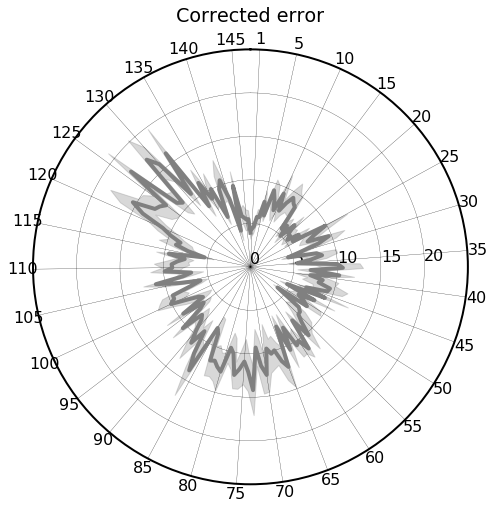

In [11]:
plt.gcf().subplots_adjust(bottom=0.35)
    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= shifted_stimulus_df[['responseError']]
df_error = shifted_stimulus_df[['responseError_SEM']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['grey'])

ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['responseError'] - df_error['responseError_SEM'], dtype='float'), 
                np.asarray(df_reset_index['responseError'] + df_error['responseError_SEM'], dtype='float'), color='gray', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_stimuluss)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_stimuluss)
plt.grid(color='black', linewidth=0.25)
plt.ylim([0, 25])
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
ax.set_yticks(np.arange(0, 25, step=5))
plt.title('Corrected error')
plt.savefig('CorrectedErr_radiologists.eps', format='eps', dpi=3000, transparent=True)
plt.savefig('CorrectedErr_radiologists.pdf', format='pdf', dpi=3000, transparent=True)

plt.show()

In [41]:
# try to plot different to see if a bug exists

Text(0.5, 0, 'Stimulus ID')

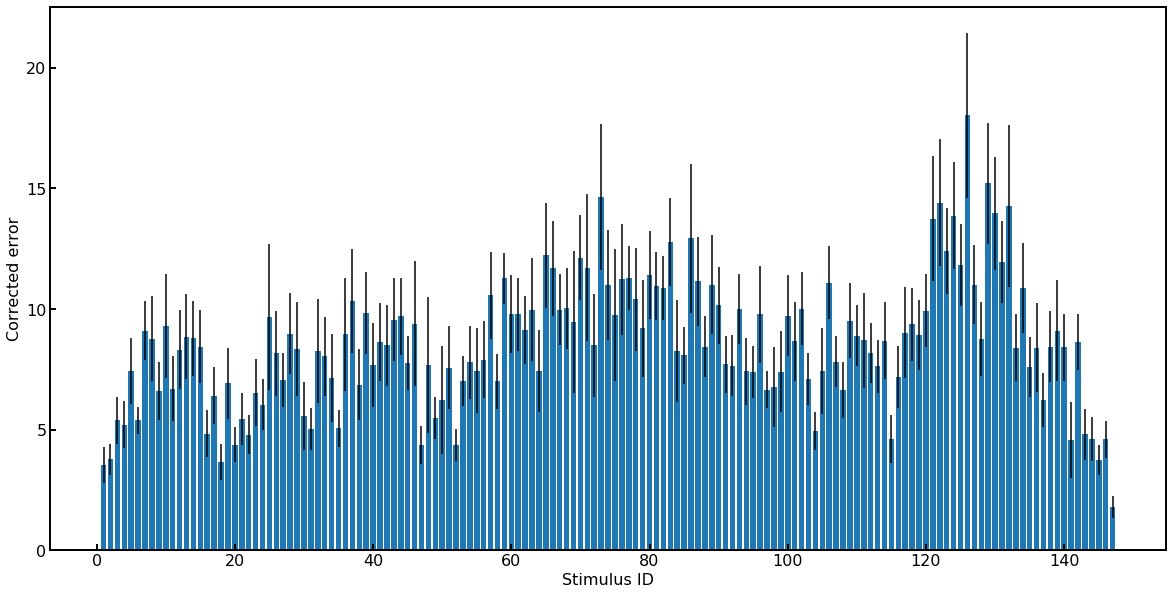

In [42]:
plt.figure(figsize=(20,10))
plt.bar(shifted_stimulus_df['shifted_stimulusID'], shifted_stimulus_df['responseError'], yerr=shifted_stimulus_df['responseError_SEM'])
plt.ylabel('Corrected error')
plt.xlabel('Stimulus ID')

In [14]:
# alldata.dropna(inplace=True)
shifted_stimulus_df = pd.DataFrame(columns=['shifted_stimulusID', 'Error', 'Error_SEM'])

row=0

for stimulus in alldata.shifted_stimulusID.unique():
    
    tmp = alldata[alldata['shifted_stimulusID'] == stimulus]
    
    mean_stimulus, sem_stimulus = ms.mean_sem_returnsem(tmp['Error'])
    
    shifted_stimulus_df.loc[row, 'shifted_stimulusID'] = stimulus
    shifted_stimulus_df.loc[row, 'Error'] = mean_stimulus
    shifted_stimulus_df.loc[row, 'Error_SEM'] = sem_stimulus
    
    row += 1
    
shifted_stimulus_df.sort_values(by=['shifted_stimulusID'], inplace=True)
shifted_stimulus_df.reset_index(drop=True, inplace=True)

In [15]:
theta = []
for deg in shifted_stimulus_df.shifted_stimulusID.unique():
    theta.append(np.pi / 73.5 * deg)
label_stimuluss = [str(i) for i in shifted_stimulus_df['shifted_stimulusID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_stimuluss = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_stimuluss.append(label_stimuluss[i])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


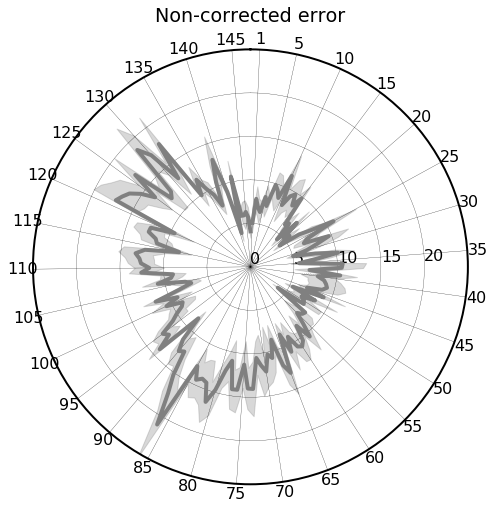

In [16]:

    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= shifted_stimulus_df[['Error']]
df_error = shifted_stimulus_df[['Error_SEM']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['grey'])

ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['Error'] - df_error['Error_SEM'], dtype='float'), 
                np.asarray(df_reset_index['Error'] + df_error['Error_SEM'], dtype='float'), color='gray', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_stimuluss)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_stimuluss)
plt.grid(color='black', linewidth=0.25)
plt.ylim([0, 25])
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
ax.set_yticks(np.arange(0, 25, step=5))
plt.title('Non-corrected error')
plt.savefig('NonCorrectedErr_radiologists.eps', dpi=3000)
plt.savefig('NonCorrectedErr_radiologists.pdf', format='pdf', dpi=3000)

plt.show()

# Count morphID 

In [17]:
alldata

,trialNumber,shifted_stimulusID,shifted_morphID,Error,responseError,SUBJECT
0,1.0,53.0,42.0,11.0,13.252246,S1
1,2.0,26.0,28.0,2.0,17.733961,S1
2,3.0,145.0,130.0,15.0,10.065948,S1
3,4.0,43.0,41.0,2.0,1.198701,S1
4,5.0,68.0,47.0,21.0,16.877476,S1
...,...,...,...,...,...,...
241,80.0,71.0,78.0,7.0,12.551372,s15
242,81.0,109.0,106.0,3.0,6.694933,s15
243,82.0,13.0,126.0,33.0,29.019065,s15
244,83.0,101.0,110.0,9.0,3.530179,s15


In [18]:
count_morphs = alldata.groupby('shifted_morphID').size().to_frame('size').reset_index()

In [19]:
count_morphs

,shifted_morphID,size
0,1.0,28
1,2.0,29
2,3.0,35
3,4.0,29
4,5.0,19
...,...,...
142,143.0,35
143,144.0,25
144,145.0,24
145,146.0,31


In [20]:
shifted_stimulus_df

,shifted_stimulusID,Error,Error_SEM
0,1,5.06667,1.18107
1,2,7.84211,1.44138
2,3,6.875,1.01137
3,4,6.3913,1.27105
4,5,8.22581,1.37544
...,...,...,...
142,143,5.95455,0.919903
143,144,5.96,1.57848
144,145,6.33333,1.33868
145,146,5.66667,1.2113


In [21]:
theta = []
for deg in count_morphs.shifted_morphID.unique():
    theta.append(np.pi / 73.5 * deg)
label_stimuluss = [str(i) for i in count_morphs['shifted_morphID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_stimuluss = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_stimuluss.append(label_stimuluss[i])


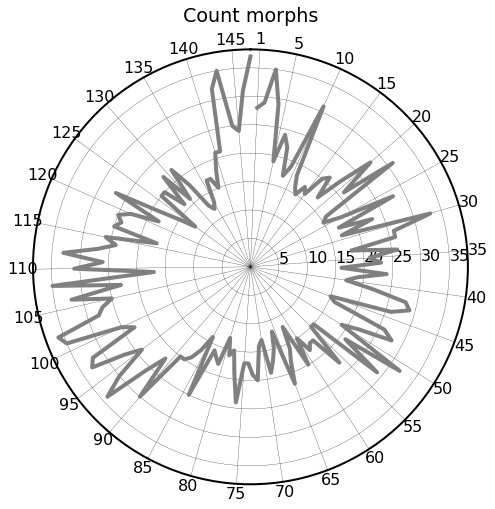

In [22]:

    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= count_morphs[['size']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['grey'])

# ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['size'] - df_size['size_SEM'], dtype='float'), 
#                 np.asarray(df_reset_index['size'] + df_size['size_SEM'], dtype='float'), color='gray', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_stimuluss)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_stimuluss)
plt.grid(color='black', linewidth=0.25)
# plt.ylim([0, 25])
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
# ax.set_yticks(np.arange(0, 25, step=5))
plt.title('Count morphs')
plt.savefig('count_morphs.eps', dpi=3000)
plt.savefig('count_morphs.pdf', format='pdf', dpi=3000)

plt.show()